# Генерируем новые признаки с помощью VGG16. Также - создаем модель для обучения с весами от VGG16. В этой версии без создания промежуточных файлов

# Версия без определения рамок - только классы

In [0]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import sklearn.metrics
from sklearn.preprocessing import OneHotEncoder

import scipy
import tqdm

In [3]:
#Mountig G drive
from glob import glob
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#Copy & extract files
!mkdir ./data
!cp '/content/drive/My Drive/fish/boxes.zip' ./data
!cp '/content/drive/My Drive/fish/train.zip' ./data
!cp '/content/drive/My Drive/fish/test_stg1.zip' ./data
!cp '/content/drive/My Drive/fish/test_stg2.7z' ./data
!unzip -n ./data/boxes.zip > /dev/null
!unzip -n ./data/train.zip > /dev/null
!unzip -n ./data/test_stg1.zip > /dev/null
!p7zip -d ./data/test_stg2.7z

!ls -al

mkdir: cannot create directory ‘./data’: File exists

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./data/                 1 file, 1152137421 bytes (1099 MiB)

Extracting archive: ./data/test_stg2.7z
--
Path = ./data/test_stg2.7z
Type = 7z
Physical Size = 1152137421
Headers Size = 82081
Method = LZMA:25
Solid = +
Blocks = 1

  0%      0% - test_stg2/image_00001.jpg                                  0% 38 - test_stg2/image_00039.jpg                                     0% 80 - test_stg2/image_00081.jpg                                     1% 125 - test_

In [7]:
#Get labels from train dir
labels = []
for path in glob('./train/*'):
    cur_label = path.split('/')[-1].lower()
    labels.append(path.split('/')[-1].lower())

#Number of classes to use later
NUM_CLASSES = len(labels) ## Need to put it everywhere!!
labels

['other', 'alb', 'bet', 'dol', 'lag', 'shark', 'nof', 'yft']

In [8]:
#One-hot encoder for labels. Also modified boxes structure an draw image function

enc = OneHotEncoder(sparse=False)
enc.fit(np.reshape(labels, (-1,1)))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [9]:
print(enc.inverse_transform([[1., 0., 0., 0., 0., 0., 0., 0.]])[0][0])

alb


In [10]:
enc.transform([['alb']])[0]

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
#Loading VGG16 model
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


58892288/58889256 [==============================] - 1s 0us/step


In [12]:
#adding final layer and freezing first layers
feature_tensor = features.layers[-1].output

output = keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = keras.layers.Conv2D(NUM_CLASSES,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2')(output)

#Making output flat
output = keras.layers.Flatten()(output)
#Fully conected layer with 8 outputs
output = keras.layers.Dense(NUM_CLASSES, activation=keras.backend.softmax)(output)

train_model = keras.models.Model(inputs=features.inputs, outputs=output, name='trainable_model')

# дообучаем последние 8 слоев
for layer in train_model.layers[:-8]:
    layer.trainable = False
train_model.summary()

Model: "trainable_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128) 

# Загружаем разметку

In [13]:
filenames = glob('./train/*/*')
len(filenames)

3777

In [0]:
#Getting image label from path name
def get_label(path):
    label = path.split('/')[2].lower()
    return enc.transform([[label]])[0]

In [15]:
get_label('./train/OTHER/img_06087.jpg')

array([0., 0., 0., 0., 0., 1., 0., 0.])

In [0]:
def draw_labels(path, true_label=None, pred_label=None, image_size=None):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img.copy(), image_size)
        
    if true_label is not None:
        label = enc.inverse_transform([true_label])[0][0]
        img = cv2.putText(img.copy(), label, (100, 100), cv2.FONT_HERSHEY_COMPLEX, 4, (0,255,0), 5)

    if pred_label is not None:
        label = enc.inverse_transform([pred_label])[0][0]
        img = cv2.putText(img.copy(), label, (100, 300), cv2.FONT_HERSHEY_COMPLEX, 4, (255,0,0), 5)

    return img

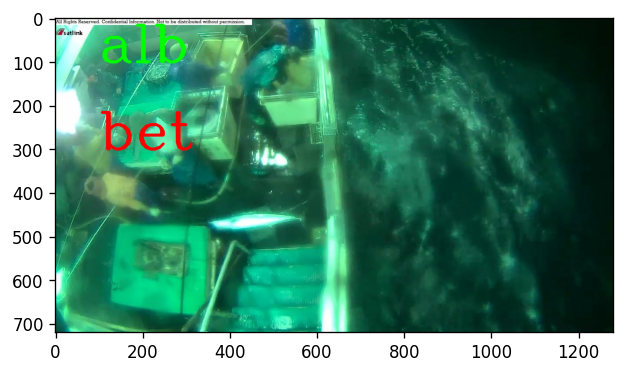

In [17]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_labels('./train/OTHER/img_06087.jpg', true_label=[1,0,0,0,0,0,0,0], pred_label=[0,1,0,0,0,0,0,0])
plt.imshow(img)

# Loading images

In [0]:
#Splitting for train & validation
random.shuffle(filenames)
train_files = filenames[:int(len(filenames)*0.8)]
val_files = filenames[int(len(filenames)*0.8):]

In [0]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))


def data_generator(files, batch_size=32):
    
    while True:
        random.shuffle(files)
        for i in range(len(files)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(files[j])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(get_label(files[j]))
                X.append(img)
            yield np.array(X), np.array(y)

# Training model

In [0]:
K = tf.keras.backend

In [0]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
train_model.compile( optimizer=adam, 
              loss=K.categorical_crossentropy,
              metrics={'dense': keras.metrics.CategoricalAccuracy()})

In [19]:
batch_size =16
steps_per_epoch = len(train_files) / batch_size

train_gen = data_generator(train_files, batch_size=batch_size)
# val_gen = data_generator(val_files, batch_size=batch_size) - no support for validation if use generators, will check manually later

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

train_model.fit_generator(generator=train_gen,
                          steps_per_epoch=steps_per_epoch,
                          epochs=10,
                          callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
189/188 [==============================] - ETA: 0s - loss: 0.9895 - categorical_accuracy: 0.7765
Epoch 00001: loss improved from inf to 0.98955, saving model to weights.01-0.990.hdf5
189/188 [==============================] - 157s 833ms/step - loss: 0.9895 - categorical_accuracy: 0.7765
Epoch 2/10
189/188 [==============================] - ETA: 0s - loss: 0.3385 - categorical_accuracy: 0.9441
Epoch 00002: loss improved from 0.98955 to 0.33855, saving model to weights.02-0.339.hdf5
189/188 [==============================] - 157s 828ms/step - loss: 0.3385 - categorical_accuracy: 0.9441
Epoch 3/10
189/188 [==============================] - ETA: 0s - loss: 0.2240 - categorical_accuracy: 0.9828
Epoch 00003: loss improved from 0.33855 to 0.22404, saving model to weights.03-0.224.hdf5
189/188 [==============================] - 157s 831ms/step - loss: 0.2240 - categorical_accuracy: 0.9828
Epoch 4/10
189/188 

In [22]:
models = sorted(glob('./weights*'))
models

['./weights.01-0.990.hdf5',
 './weights.02-0.339.hdf5',
 './weights.03-0.224.hdf5',
 './weights.04-0.167.hdf5',
 './weights.05-0.151.hdf5',
 './weights.06-0.121.hdf5',
 './weights.07-0.104.hdf5',
 './weights.08-0.092.hdf5',
 './weights.09-0.082.hdf5',
 './weights.10-0.072.hdf5']

In [54]:
cross_ent = []
hamm_acc = []

for weights in models:
    train_model.load_weights(weights)
    y_true = []
    y_pred = []
    y_pred_int = []
    for cur_file in tqdm.tqdm_notebook(val_files):
        img_shape, img = load_img(cur_file)
        pred = train_model.predict(np.array([img]))[0]

        y_true.append(get_label(cur_file))
        y_pred.append(pred)
        y_pred_int.append(np.eye(1, NUM_CLASSES, np.argmax(pred))[0])

    ce = sklearn.metrics.log_loss(y_true, y_pred)
    acc = sklearn.metrics.hamming_loss(y_true, y_pred_int)
    print(weights, ce, acc)
    cross_ent.append(ce)
    hamm_acc.append(acc)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.01-0.990.hdf5 1.302171342225346 0.07374338624338625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.02-0.339.hdf5 0.5563778949840378 0.041666666666666664


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.03-0.224.hdf5 0.3002466933746806 0.01521164021164021


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.04-0.167.hdf5 0.22303624358823962 0.01488095238095238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.05-0.151.hdf5 0.151407437670973 0.00958994708994709


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.06-0.121.hdf5 0.12938881035807936 0.008597883597883597


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.07-0.104.hdf5 0.13338604631941572 0.006944444444444444


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.08-0.092.hdf5 0.12531435260923574 0.006283068783068783


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.09-0.082.hdf5 0.12126002239524282 0.006283068783068783


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



./weights.10-0.072.hdf5 0.11830486403792678 0.005621693121693121


In [0]:
!cp weights.* './drive/My Drive/fish2'

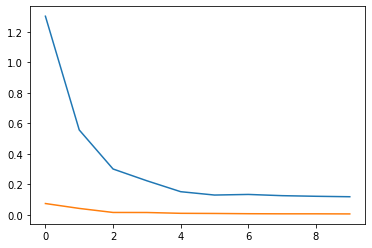

In [58]:
plt.plot(cross_ent)
plt.plot(hamm_acc)
plt.show()

In [0]:
#will use ./weights.06-0.121.hdf5 for predictions
train_model.load_weights('./drive/My Drive/fish2/weights.06-0.121.hdf5')

In [62]:
#Test stage 1
sub_files = glob('./test_stg1/*')

sub_scores = []

for cur_file in tqdm.notebook.tqdm(sub_files):
    img_shape, img = load_img(cur_file)
    pred = train_model.predict(np.array([img]))[0]
    sub_scores.append(pred)

In [65]:
sub_img = []
for cur_file in sub_files:
    sub_img.append(cur_file.split('/')[-1])

sub_img[:10]

['img_00320.jpg',
 'img_05038.jpg',
 'img_05882.jpg',
 'img_02119.jpg',
 'img_02379.jpg',
 'img_04719.jpg',
 'img_00858.jpg',
 'img_01802.jpg',
 'img_03952.jpg',
 'img_06211.jpg']

In [0]:
with open('/content/drive/My Drive/fish2/Submission v1', 'w') as dst:
    dst.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for path, score in zip(sub_img, sub_scores):
        dst.write('%s,%f,%f,%f,%f,%f,%f,%f,%f\n' % (path, score[0],score[1],score[2],score[3],score[4],score[5],score[6],score[7]))

In [24]:
#Test stage 2
sub_files = glob('./test_stg2/*')

sub_scores = []

for cur_file in tqdm.tqdm_notebook(sub_files):
    img_shape, img = load_img(cur_file)
    pred = train_model.predict(np.array([img]))[0]
    sub_scores.append(pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [29]:
sub_img = []
for cur_file in sub_files:
    str = 'test_stg2/' + cur_file.split('/')[-1]
    sub_img.append(str)

sub_img[:10]

['test_stg2/image_10712.jpg',
 'test_stg2/image_07868.jpg',
 'test_stg2/image_06207.jpg',
 'test_stg2/image_00693.jpg',
 'test_stg2/image_06793.jpg',
 'test_stg2/image_04129.jpg',
 'test_stg2/image_02982.jpg',
 'test_stg2/image_03518.jpg',
 'test_stg2/image_00114.jpg',
 'test_stg2/image_10509.jpg']

In [0]:
with open('/content/drive/My Drive/fish2/Submission v2', 'a') as dst:
    # dst.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for path, score in zip(sub_img, sub_scores):
        dst.write('%s,%f,%f,%f,%f,%f,%f,%f,%f\n' % (path, score[0],score[1],score[2],score[3],score[4],score[5],score[6],score[7]))

Kaggle result: Public score 1.90178
Private score 3.72557

Мне кажется, что большая часть результатов посчитана по 1000 файлов, а не по 13к, что приводит к совершенно другим оценкам.
